## Importing relevant libraries

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg as la
import scipy.spatial as spat
from scipy.stats import unitary_group
from scipy.stats import moment
from scipy.stats import skew, kurtosis
from scipy.optimize import curve_fit
from scipy.linalg import norm
import matplotlib.pyplot as plt
import math
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from qiskit import *
from qiskit import execute
from qiskit import transpiler
from qiskit import QuantumCircuit
from qiskit.circuit.add_control import add_control
from qiskit.extensions import UnitaryGate
from qiskit.circuit.reset import Reset
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit.library.standard_gates import IGate, UGate, U3Gate
from qiskit.dagcircuit import DAGOpNode, DAGInNode
from qiskit.quantum_info.operators.predicates import matrix_equal
from qiskit.quantum_info.synthesis import OneQubitEulerDecomposer
from qiskit.transpiler.passes.optimization import Optimize1qGates
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.transpiler.exceptions import TranspilerError
from math import fsum
from scipy.optimize import minimize
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.dagcircuit import DAGCircuit
from qiskit.providers.models import BackendConfiguration
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.transpiler.passes import BasisTranslator
from qiskit import QuantumCircuit, IBMQ, transpile
from qiskit.circuit import Delay
from qiskit.circuit.library import XGate, YGate, ZGate, RXGate, RYGate, RZGate
from qiskit.transpiler.passes import ALAPSchedule
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.visualization import plot_histogram
from qiskit.visualization import timeline_drawer
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.providers.aer import AerSimulator

# Import Paddle libraries
import paddle
from paddle_quantum.ansatz import Circuit
from paddle_quantum.linalg import dagger

C:\Users\abc\anaconda3\lib\site-packages\openfermion\hamiltonians\hartree_fock.py:11: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  from scipy.optimize.optimize import OptimizeResult
C:\Users\abc\anaconda3\lib\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
C:\Users\abc\anaconda3\lib\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: ht

## Saving IBMQ account

In [ ]:
IBMQ.save_account('20679dd22551941f9255655deabc9d69d569091c01ec92bdb01c2999ac7c55e771b66be79444a46d21a51f3a6894c01f6485b9692ef9d620849186b8e67964cf')

## Loading IBMQ account

In [ ]:
IBMQ.load_account()

## Importing IBMQ provider

In [ ]:
provider = IBMQ.get_provider('ibm-q')

## Implementation of the classical subroutine

### Note: This constructs the Hermitian form of the Fokker-Planck matrix and defines additional functions for subsequent analysis of the zeromode

In [2]:
## Classical implementation
"""
Purpose: 
    Find the analytical solution given the input parameters
Input: 
    x: array representing the x coordinates over which the solution is to be found
    a, Γ: parameters for the Ornstein-Uhlenbeck equation
Output:
    y: array of the value of the analytical solution over x
"""

def OrnsteinUhlenbeck(x, a = 1, gamma = 1):
    y = np.sqrt(a/(2*np.pi*gamma)) * np.exp((-a * x ** 2)/(2*gamma))
    
    return y

"""
Purpose:
    Calculate the weighted Hermite polynomials using recursive relations up to H_n
Input:
    n: the highest number of Hermite polynomials to be evaluated at
    x: the value of x at which the weighted Hermite polynomials are to be evaluated
Output:
    Hermite: the value of the weighted Hermite polynomials
Example: HermiteSeries(2, 4) -> [H_0(4), H_1(4), H_2(4)]
"""

def HermiteSeries(n, x):
    Hermite = np.zeros((1, n+1))
    Hermite[0][0] = 1.0 * np.exp(-x**2/2)
    Hermite[0][1] = 2.0 * x *np.exp(-x**2/2)
    
    for ni in range(1, n):
        Hermite[0][ni+1] = 2*x*Hermite[0][ni] - 2*ni*Hermite[0][ni-1]
    
    return Hermite

"""
Purpose:
    Reconstruct the functions represented by the coefficients of weighted Hermite polynomials in spatial coordinates
Input:
    x: array containing the x values over which the function is to be evaluated
    coefficients: the coefficients corresponding to the Hermite polynomials (should be zero-mode of the operator)
    nmax: the highest order of weighted Hermite polynomials used
    s: the scaling factor
Output:
    y: the reconstruction
"""

def project(x, coefficients, nmax, s):
    
    y = np.zeros(x.shape)
    
    for i in (range(len(x))):
        x0 = s*x[i]
        hermite_values = HermiteSeries(nmax, x0)
        y[i] += np.dot(hermite_values, coefficients)
        
    return (x, y)

"""
Purpose:
    Normalize the PDF so that the area under the curve is 1
Input:
    x, y: arrays representing the unnormalized
Output:
    (x, y): normalized PDF
"""

def normalize(x, y):
    dx = x[1] - x[0]
    sum = 0
    
    for i in range(len(x)):
        sum = sum + (y[i] * dx)
    
    y = y/sum
    
    return (x, y)

"""
Purpose:
    Calculate the RMS
Input:
    y_op, y: the y values generated by the operator and the analytical solution
Output:
    RMS
"""

def rms_diff(y_op, y):
    return np.sqrt(np.sum((y_op-y)**2)/len(y))

"""
Purpose:
    Find s given a and Γ such that the projection in Hermite space is just H_0
Input:
    a, Γ: parameters for Ornstein-Uhlenbeck
Output:
    s
"""

def special_s(a, gamma):
    return np.sqrt(a/gamma)

def euler_representation(z):
    A = abs(z)
    phase = math.atan(z.imag/z.real)
    
    return A, phase

def generate_positive_semidefinite_matrix(eigenvalues):
    ## Function to transform the FPE operator to the Hermite basis and return a finite truncated matrix for the ...
    ## ... FPE operator
    
    n = len(eigenvalues)
    s = np.diag(eigenvalues)
    q, _ = la.qr(np.random.rand(n, n))
    semidef = np.dot(np.transpose(q), s)
    semidef = np.dot(semidef, q)
    
    return semidef

def normalize_probability(y, dx):
    ## Function to return a normalized PDF 
    
    total = np.sum(y) * dx
    y = y / total
    
    return y

def perturbed_ornstein_uhlenbeck(x0, a = 1, gamma = 1, c = 0, shift = 0):
    ## Function to compute the exact solution to the perturbed Ornstein-Uhlenbeck equation
    
    assert len(x0) > 1, "Error: x0 should be a vector"

    x = x0 - shift
    y = np.exp(-a*x**2 /(2*gamma) - c*x**4 /(4*gamma))
    dx = x[2] - x[1]
    
    y = normalize_probability(y, dx)
    
    return y

def special_L(a, gamma):
    ## Function to compute the characteristic length scale
    
    return np.sqrt(a/gamma)

def delta(N, n):
    ## Function to implement the Kronecker delta function
    
    if N == n:
        return 1
    else:
        return 0

def f(N,n):
    return 0.5*( np.sqrt(n*(n-1))*delta(N,n-2) + delta(N,n) - np.sqrt((n+1)*(n+2))*delta(N,n+2))

def g(N,n, L):
    return 0.5*L**2*( np.sqrt(n*(n-1))*delta(N,n-2) - (2*n+1)*delta(N,n) + np.sqrt((n+1)*(n+2))*delta(N,n+2))

def t(N, n, L):
    val1 = np.sqrt(n*(n-1)*(n-2)*(n-3))*delta(N, n-4)
    val2 = (2*n+2)*np.sqrt(n*(n-1))*delta(N, n-2)
    val3 = (6*n+3)*delta(N, n)
    val4 = -2*n*np.sqrt((n+1)*(n+2))*delta(N, n+2)
    val5 = -1*np.sqrt((n+1)*(n+2)*(n+3)*(n+4))*delta(N, n+4)

    return 1/(4*L**2)*( val1 + val2 + val3 + val4 + val5 )

def element_perturbed(N, n, L, a, c, gamma):
    ## Function to compute the matrix elements of the finite truncated matrix for the FPE operator (in the Hermite basis)
    
    return -(a*f(N,n) + c*t(N, n, L) + gamma*g(N, n, L))

def create_operator_perturbed(nmax, L, a, c, gamma):
    ## Function to generate the FPE operator matrix in the Hermite basis
    op = np.zeros((nmax+1, nmax+1))
    
    for N in range(nmax+1):
        row = N
        for n in range(nmax+1):
            col = n
            op[row, col] = element_perturbed(N, n, L, a, c, gamma)
    
    """
    if np.any(np.nan, op):
        print("There's an nan in the operator")
    elif np.any(np.inf, op):
        print("There is an inf in the operator")
    """

    return op

def state_n(nmax, x0, L):
    ## Function to compute the Hermite polynomials upto the order specified by nmax
    
    assert L > 0, "Error (state_n): input L must be greater than or equal to 0"

    states = np.zeros(nmax + 1)
    x = x0*L

    states[0] = np.sqrt(L*np.sqrt(1/np.pi))* 1.0 * np.exp(-x**2/2)

    if nmax > 0:
        states[1] = np.sqrt(L*np.sqrt(1/np.pi))* (1/np.sqrt(2)) * 2.0 * x * np.exp(-(x**2)/2)
    
    for ni in range(2, nmax + 1):
        states[ni] = ((np.sqrt(2)*x) / np.sqrt(ni))*states[ni-1] - (ni-1)/np.sqrt((ni)*(ni-1))*states[ni-2]

    return states

def integrate_eigenvector(x0, y, nmax, L):
    ## Function to compute the coefficients corresponding to the calculated Hermite polynomials by numerical integration
    ## Note: here, we use the left-hand integration method
    
    dx = x0[2] - x0[1]
    eigenvector = np.zeros(nmax + 1)

    for i in range(len(x)):

        states = state_n(nmax, x0[i], L)
        states = states * y[i] * dx

        eigenvector = eigenvector + states
        
    return {"eigenvector" : eigenvector, "dx" : dx, "nmax" : nmax, "x0" : x0, "L" : L}

def make_operator_even(op):
    op_new = np.zeros((op.shape[0]//2, op.shape[1]//2))
    
    for row in range(op_new.shape[0]):
        for col in range(op_new.shape[1]):
            op_new[row, col] = op[row*2, col * 2]
    
    return op_new

def reconstruct_eigenvector(cache, normalize = True, only_even = False):
    ## Function to reconstruct the PDF using the cache obtained previously
    
    eigenvector = cache["eigenvector"]
    nmax = cache["nmax"]
    x0 = cache["x0"]
    dx = cache["dx"]
    L = cache["L"]
    
    if not only_even:
        eigenvector = cache["eigenvector"]
    else:
        eigenvector_old = cache["eigenvector"]
        eigenvector = np.zeros(nmax + 1)
        
        for i in range(len(eigenvector_old)):
            eigenvector[2*i] = eigenvector_old[i]

    y = np.zeros(len(x0))

    for i in range(len(x0)):
        states = state_n(nmax, x0[i], L)
        y[i] += (np.dot(states, eigenvector))
    if normalize:   
        y = normalize_probability(y, dx)
        
    return (x0, y)

def find_zeromode(op_nonhermitian, nmax, x0, dx, L, which = "single", only_even = False):
    ## Function to compute the zeromode, its position, and the eigenvalue corresponding to the zeromode
    
    assert which == "nonhermitian" or which == "single", "Error: currently only supports which = {\"nonhermitian\", \"single\"}"
    
    if only_even:
        op_processed = make_operator_even(op_nonhermitian)
    else:
        op_processed = op_nonhermitian
        
    if which == "nonhermitian":
        op = op_processed
    elif which == "single":
        op = np.dot(np.transpose(op_processed), op_processed)

    eigenvalues, eigenvectors = la.eig(op)

    index = np.argmin(np.real(eigenvalues)**2)

    min_eigenval = eigenvalues[index]
    
    zeromode = eigenvectors[:, index]

    return {"operator" : op, "which" : which, \
            "eigenvector" : np.real(zeromode), "index" : index, "eigenvalue" : np.real(min_eigenval), \
            "nmax" : nmax, "x0" : x0, "dx" : dx, "L" : L, "spectrum" : eigenvalues, "P" : eigenvectors}

def rms_diff(y0, y, sigdigits = 0):
    ## Function to compute the RMS difference between the analytically computed PDF and the one ...
    ## ... obtained using the FPE operator
    
    assert len(y0) == len(y), "Error: the length of y0 and y should be the same"
    diff = np.sum((y0-y)**2)/len(y0)
    
    return np.sqrt(diff)

def analyze_collapse(initial_state, P, index):
    num_basis = P.shape[1]
    coefficients = np.zeros((num_basis, ))

    for i in range(num_basis):
        basis = P[:, i]
        basis = normalize_eigenvector(basis)

        coefficients[i] = np.dot(basis, initial_state)

    normalized_coefficients = normalize_eigenvector(coefficients)

    reconstruction = np.zeros((P.shape[0], ))

    for i in range(num_basis):
        basis = P[:, i]
        basis = normalize_eigenvector(basis)

        added_vector = coefficients[i] * basis
        reconstruction = reconstruction + added_vector

    probability = normalized_coefficients ** 2
    
    probability_zeromode = probability[index]
    assert np.sum(probability) - 1 < 0.00001, "Error: unity normalization of probability is not observed"

    print("The initial_state is: ")
    print(initial_state)
    print()

    print("The coefficient expansion is: ")
    print(coefficients)
    print()

    print("The normalized coefficient expansion is: ")
    print(normalized_coefficients)
    print()

    print("The reconstructed vector is: ")
    print(reconstruction)
    print()

    print("The probability of collapsing into each eigenvector is: ")
    print(probability)
    print()

    print("The probability of collapsing into the zeromode is: ")
    print(probability_zeromode)
    print()
    
    return probability_zeromode, probability

def get_unitary(matrix, add_half = False):
    """
    Purpose: given a matrix, returns the unitary, hermitian matrix to be diagonalized
    Input: matrix -> the matrix to be diagonalized
    Output: U -> the unitary matrix
            nqubits -> the number of qubis needed to represent the basis of U
            dimension -> the dimension of the original matrix
    """
    assert matrix.ndim == 2, "Error: Only a matrix maybe processed"
    assert matrix.shape[0] == matrix.shape[1], "Error: Only a square matrix maybe processed"

    if np.any(np.transpose(matrix) != matrix):
        matrix_T = np.transpose(matrix)
        matrix = np.dot(matrix_T, matrix)

    ## Finding the dimension of the matrix
    dimension_hermitian = matrix.shape[0]

    ## Finding the number of qubits required to represent the matrix
    nqubits = int(np.ceil(np.log2(dimension_hermitian)))

    ## Construct the relevant matrix
    op_dim = 2 ** nqubits
    op = np.eye(op_dim)
    op[0:dimension_hermitian, 0:dimension_hermitian] = np.copy(matrix)

    if add_half:
        op = op + np.pi * np.eye(op.shape[0])

    U = la.expm(1j*op)

    # Get the dimensions of the unitary matrix
    dimension = U.shape[0]

    return U, nqubits, dimension

## Helper functions

In [3]:
def find_probability(eigenvector_raw):
    """
    Purpose: Find the probability associated with each basis of an eigenvector
    Input: eigenvector_raw -> Numpy array documenting the number of times each basis is detected within the eigenvector
    Output: eigenvector_prob -> Numpy array documenting the probability of detecting each basis
    """
    count_total = np.sum(eigenvector_raw)
    eigenvector_prob = eigenvector_raw / count_total
    
    return eigenvector_prob

def find_amplitude(eigenvector_prob):
    """
    Purpose: Finding the probability amplitude of each basis using quantum mechanics
    Input: eigenvector_prob -> Numpy array documenting the probability that each basis is measured
    Output: eigenvector -> Numpy array representing the eigenvector
    """
    eigenvector = np.sqrt(eigenvector_prob)
    return eigenvector

def normalize_eigenvector(vector):
    """
    Purpose: Normalizes a vector such that its norm is 1
    Input: vector -> The vector to be normalized
    Output: vector -> The normalized vector
    """
    L2 = np.sum(np.square(vector))
    vector = vector / np.sqrt(L2)

    return vector

def make_operator_even(op):
    op_new = np.zeros((op.shape[0]//2, op.shape[1]//2))

    for row in range(op_new.shape[0]):
        for col in range(op_new.shape[1]):
            op_new[row, col] = op[row*2, col * 2]

    return op_new

## Computing the steady-state PDF

In [4]:
def get_pdf(n, x, dx, L, shift, zeromode_qpe, normalize = True, make_even = False):
    # Function to construct the ground state PDF using the VQSVD zeromode
    
    if not make_even:
        eigenvector = zeromode_qpe
    else:
        eigenvector_old = zeromode_qpe
        eigenvector = np.zeros(n + 1)
        for i in range(len(eigenvector_old)):
            eigenvector[2*i] = eigenvector_old[i]
            
    x0 = x - shift
    
    # Computing the PDF
    y = np.zeros(len(x0))

    for i in range(len(x0)):
        states = state_n(nmax, x0[i], L)
        y[i] += (np.dot(states, eigenvector))
    
    if normalize:
        y = normalize_probability(y, dx)

    return x0, y

## Computing expectation values

In [5]:
def get_expectation(x, y):
    # Function to compute the expectation value of x and using the estimated ground state PDF
    # Note: Ground state PDF already normalized
    
    # Calculate expectation values
    expectation_x, expectation_x_square = 0, 0
    
    for x_val, pdf in zip(x, y):
        expectation_x += x_val * pdf
        expectation_x_square += x_val**2 * pdf
        
    return expectation_x, expectation_x_square

def expect_verify(x, y, n):
    # Function to verify if all odd order moments of the ground state PDF (symmetric about 0) vanish
    
    # Calculate expectation values
    expectation_val = 0
    
    for x_val, pdf in zip(x, y):
        expectation_val += x_val**n * pdf
        
    if n % 2 != 0:
        if expectation_val < 1e-10: # error tolerance applied is 1e-10
            return True
        else:
            return False
    else:
        return # else, if n is even, the function returns None

## Computing PDF moments

In [6]:
def get_moments(y, moments):
    # Function to compute the moments of the ground state PDF (about the mean)
    
    # Initialization
    moment_vals = []
    
    for i in range(len(moments)):
        moment_val = moment(y, moments[i])
        moment_vals.append(moment_val)
        
    return moment_vals

## Defining a cutoff and generating plots accordingly

In [7]:
def cutoff_graph(x, y, y_cutoff):
    # Function to obtain the bounded x and y values (PDF on the log scale)
    
    x_values = [x_val for x_val, y_val in zip(x, y) if y_val >= y_cutoff]
    y_values = [y_val for y_val in y if y_val >= y_cutoff]
    
    return x_values, y_values

## Computing PDF maximas

In [8]:
def get_maxima(x, y):
    # Function to determine the maximas in the steady-state PDFs 
    
    # Extract the positive side of the PDF
    x_positive = [x_val for x_val in x if x_val >= 0]
    y_positive = [y_val for x_val, y_val in zip(x, y) if x_val >= 0]
    
    # Determine the maximum
    max_idx = np.argmax(y_positive)
    x_max = x_positive[max_idx]
    
    return x_max

# Classical and quantum analysis

## Constructing the FPE operator

In [9]:
# Defining parameters
nmax = 15
dx = 0.01
a = 10
gamma = 2
c = 3
L = 2
shift = 0

#3, 5, 1, 1
x = np.linspace(-10, 10, int((20)/dx))
y = perturbed_ornstein_uhlenbeck(x, a = a, gamma = gamma, c = c, shift = shift)

## Finding the zeromode through direct integration
cache_projection = integrate_eigenvector(x, y, nmax, L)
x_projection, y_projection = reconstruct_eigenvector(cache_projection)

## Finding the zeromode through diagonalization
op_nonhermitian = create_operator_perturbed(nmax, L, a, c, gamma)
only_even = True

cache_diagonalization = find_zeromode(op_nonhermitian, nmax, x, dx, L, which = "single", only_even = only_even)
x_diagonalization, y_diagonalization = reconstruct_eigenvector(cache_diagonalization, only_even = only_even)

## Moments array
moments = [1, 2, 3, 4, 5] # to compute the moments of the distribution(s)

## Analysis of the diagonalization

In [10]:
num_basis = cache_diagonalization['P'].shape[1]
initial = np.zeros((num_basis, ))
initial[0] = 1
index = cache_diagonalization['index']

probability_zeromode, probability = analyze_collapse(initial, cache_diagonalization['P'], index)

The initial_state is: 
[1. 0. 0. 0. 0. 0. 0. 0.]

The coefficient expansion is: 
[-2.09097133e-05  1.28260168e-04 -5.37327665e-04  1.94151345e-03
 -8.77410983e-03  9.94059138e-01  1.03451736e-01  3.26053369e-02]

The normalized coefficient expansion is: 
[-2.09097133e-05  1.28260168e-04 -5.37327665e-04  1.94151345e-03
 -8.77410983e-03  9.94059138e-01  1.03451736e-01  3.26053369e-02]

The reconstructed vector is: 
[1.00000000e+00 1.86309301e-15 5.48172618e-16 4.51028104e-17
 1.81278603e-16 2.42861287e-17 2.47198095e-17 7.35089073e-17]

The probability of collapsing into each eigenvector is: 
[4.37216111e-10 1.64506708e-08 2.88721020e-07 3.76947446e-06
 7.69850033e-05 9.88153570e-01 1.07022617e-02 1.06310799e-03]

The probability of collapsing into the zeromode is: 
0.9881535702138395



## Loading the FPE operator

In [11]:
matrix = cache_diagonalization['operator']

# Defining the matrix to be diagonalized
U, n_query_qubits, dimension = get_unitary(matrix, add_half = False)

# Printing out the unitary matrix
print(U)
print(dimension)

[[ 0.99664199-5.81641391e-03j -0.02919563-5.30307044e-02j
   0.0493071 +8.48411683e-04j  0.02003448+5.17266982e-03j
   0.0087362 -8.27418230e-04j  0.00701582+6.06942326e-04j
   0.00336923+2.45519953e-04j  0.00286367+1.02346221e-04j]
 [-0.02919563-5.30307044e-02j  0.74404171-4.84604323e-01j
   0.41166184+1.21876415e-03j  0.14398182+1.17554102e-02j
   0.1056432 +1.27759794e-02j  0.06565036+6.50727122e-03j
   0.03188242+3.48588668e-03j  0.02904967+3.38852820e-03j]
 [ 0.0493071 +8.48411683e-04j  0.41166184+1.21876415e-03j
  -0.52075291-5.61973458e-01j -0.41432185+6.91984686e-02j
  -0.16207468+6.50688860e-02j -0.1486121 +2.25610935e-02j
  -0.07893338+1.93695008e-02j -0.06922916+1.25417685e-02j]
 [ 0.02003448+5.17266982e-03j  0.14398182+1.17554102e-02j
  -0.41432185+6.91984686e-02j  0.35491717-7.73428299e-01j
   0.22943503+1.07501238e-01j -0.02497615-2.52083034e-02j
   0.10950187+1.77575220e-02j  0.01813622+1.79805568e-03j]
 [ 0.0087362 -8.27418230e-04j  0.1056432 +1.27759794e-02j
  -0.16207

## Exact diagonalization of the unitary matrix

In [12]:
## Classical diagnonalization
A, P = la.eig(U)

A_real = np.real(A)
index = np.where(A_real == np.amax(A_real))[0][0]

eigenvalue = A[index]
zeromode_classic = P[:, index]

zeromode_classic = np.real(normalize_eigenvector(zeromode_classic))
zeromode_classic = np.reshape(zeromode_classic, (zeromode_classic.size, 1))

print("the available eigenvalues are: \n" + str(A))
print()

## Printing relevant results
print("the available eigenvalues are: \n" + str(A))
print()

print("The minimum eigenvalue located is: \n" + str(eigenvalue))
print()

print("The minimum zeromode located is: \n" + str(np.real(zeromode_classic)))
print()

# Estimating the probability of collapse into the zeromode
initial = np.zeros((P.shape[0], ))
initial[0] = 1
    
probability_zeromode, probability = analyze_collapse(initial, np.real(P), index)

# Printing out the spectrum of eigenvectors
print('The spectrum of eigenvectors is:' )
print(P)
print()

the available eigenvalues are: 
[ 1.        +1.11216132e-05j -0.85390745-5.20424887e-01j
  0.87346344-4.86889739e-01j  0.63389238-7.73421261e-01j
  0.94546932-3.25711179e-01j -0.2326689 -9.72556005e-01j
 -0.66907329-7.43196429e-01j -0.49344916-8.69774640e-01j]

the available eigenvalues are: 
[ 1.        +1.11216132e-05j -0.85390745-5.20424887e-01j
  0.87346344-4.86889739e-01j  0.63389238-7.73421261e-01j
  0.94546932-3.25711179e-01j -0.2326689 -9.72556005e-01j
 -0.66907329-7.43196429e-01j -0.49344916-8.69774640e-01j]

The minimum eigenvalue located is: 
(0.9999999999383281+1.1121613231690475e-05j)

The minimum zeromode located is: 
[[ 9.94059138e-01]
 [-1.08702764e-01]
 [ 1.65627715e-03]
 [ 4.87619708e-03]
 [-1.88428944e-03]
 [ 2.26921154e-04]
 [ 6.83588404e-05]
 [-1.07365649e-04]]

The initial_state is: 
[1. 0. 0. 0. 0. 0. 0. 0.]

The coefficient expansion is: 
[ 9.94059138e-01 -3.26053369e-02  1.03451736e-01 -8.77410983e-03
  5.37327665e-04  1.94151345e-03  1.28260168e-04 -2.09097133

## Exact diagonalization of the non-Hermitian FPE operator (needed for VQE simulations)


In [13]:
# Use only even-order Hermite polynomials
op_nonhermitian = make_operator_even(op_nonhermitian)

# Compute the non-Hermitian zeromode
A, P = sp.linalg.eig(op_nonhermitian)

A_real = np.real(A)
index = np.where(A_real == np.amin(A_real))[0][0]

eigenvalue = A[index]
zeromode_nonhermitian = P[:, index]

zeromode_nonhermitian = np.real(normalize_eigenvector(zeromode_nonhermitian))

## Printing results
print('The zeromode of the non-Hermitian FPE operator is:')
print(zeromode_nonhermitian)
print()

The zeromode of the non-Hermitian FPE operator is:
[-9.94021642e-01  1.09047152e-01 -1.60000095e-03 -4.83988495e-03
  1.90960849e-03 -2.14699245e-04 -6.07369212e-05  1.13499317e-04]



## Quantum (VQD) analysis

### Importing relevant libraries

In [14]:
# Libraries for implementing the VQD algorithm
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.primitives import Sampler, Estimator
# from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Sampler, Session, Options
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes, TwoLocal, EfficientSU2
from qiskit.algorithms.optimizers import *
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.algorithms.eigensolvers import EigensolverResult, VQD

# Import classical optimizers
from qiskit_algorithms.optimizers import SPSA, P_BFGS, COBYLA

C:\Users\abc\anaconda3\lib\site-packages\qiskit\opflow\operator_globals.py:52: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.pauli_op.PauliOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  X = make_immutable(PauliOp(Pauli("X")))
C:\Users\abc\anaconda3\lib\site-packages\qiskit\opflow\primitive_ops\pauli_op.py:54: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.primitive_op.PrimitiveOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  super().__init__(primitive, coeff=coeff)
C:\Users\abc\anaconda3\lib\site-packages\qiskit\opflow\primitive_ops\primitive_op.py:110: DeprecationWarning: The class ``qiskit.opflow.operator_base.OperatorBase`` is deprecated as of qiskit-terra 0.24.0. It will be removed 

### Initialization

In [24]:
# Initialization of arrays for storing intermediate VQD results
counts_noisy, values_noisy, steps_noisy = [], [], []
counts_noiseless, values_noiseless, steps_noiseless = [], [], []

def callback_noisy(eval_count, params, value, meta, step):
    # Function to store intermediate values from VQD (noisy simulation)
    
    counts_noisy.append(eval_count)
    values_noisy.append(value)
    steps_noisy.append(step)
    
def callback_noiseless(eval_count, params, value, meta, step):
    # Function to store intermediate values from VQD (noisy simulation)
    
    counts_noiseless.append(eval_count)
    values_noiseless.append(value)
    steps_noiseless.append(step)

### Running VQD

In [34]:
# Import Statevector and SparsePauliOp
from qiskit.quantum_info import SparsePauliOp, Statevector

# Import a fake backend and Qiskit simulators and/or noise libraries
from qiskit.providers.fake_provider import FakeMontreal, FakeMumbai, FakeWashington, FakeGuadalupe
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator as AerEstimator 
from qiskit_aer.noise import NoiseModel

def run_VQD(matrix, k, RealAmps = True, bfgs = True, noise = True):
    # Function to implement the VQD algorithm
    
    dimension = matrix.shape[0]
    num_qubits = int(np.log2(dimension))
    
    # Define the qubit Hamiltonian
    qub_hamiltonian = SparsePauliOp.from_operator(matrix)
    
    # Define the circuit ansatz
    if RealAmps:
        ansatz = RealAmplitudes(num_qubits = num_qubits, reps = 4)
    else:
        ansatz = EfficientSU2(num_qubits = num_qubits, reps = 4)
    
    # Determine the number of variational parameters
    num_parameters = ansatz.num_parameters
    
    # Initialize the optimizer and the initial point
    initial_point = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)
    
    # Initializing the estimator, sampler, and fidelity
    estimator = Estimator()
    sampler = Sampler()
    fidelity = ComputeUncompute(sampler)
    
    # Get the classical optimizer
    if bfgs:
        optimizer = P_BFGS(maxfun = 1000)
    else:
        optimizer = SPSA(maxiter = 150)
    
    # Run the VQD simulation 
    if not noise: # if False, run a noiseless simulation
        vqd = VQD(estimator = estimator, fidelity = fidelity, ansatz = ansatz, optimizer = optimizer, \
                  k = k, initial_point = initial_point, callback = callback_noiseless)
        result = vqd.compute_eigenvalues(operator = qub_hamiltonian)
        
        # Get the corresponding zeromode
        optimal_params = result.optimal_points
        zeromode_points = optimal_params[0]
        final_circuit = ansatz.assign_parameters(zeromode_points)
        zeromode_vqd = Statevector.from_instruction(final_circuit)
        
    else: # if True, run a noisy simulation
        # Get the backend
        backend = provider.get_backend('ibm_montreal')
        
        # Get the noise characteristics
        noise_model = NoiseModel.from_backend(backend) # get the noise model
        coupling_map = backend.configuration().coupling_map # get the coupling map
        basis_gates = noise_model.basis_gates # get the basis gates
        
        # Initialize the noisy estimator for VQD
        noisy_estimator = AerEstimator(
        backend_options = {
            "coupling_map": coupling_map,
            "noise_model": noise_model,
            "basis_gates": basis_gates,
        },
        run_options = {"seed": 1, "shots": 3000},
        transpile_options = {"seed_transpiler": 1},
    )
        # Run the VQD algorithm
        vqd = VQD(estimator = noisy_estimator, fidelity = fidelity, ansatz = ansatz, optimizer = optimizer, \
                  k = k, initial_point = initial_point, callback = callback_noisy)
        result = vqd.compute_eigenvalues(operator = qub_hamiltonian)
        
        # Get the corresponding zeromode
        optimal_params = result.optimal_points
        zeromode_points = optimal_params[0]
        final_circuit = ansatz.assign_parameters(zeromode_points)
        zeromode_vqd = Statevector.from_instruction(final_circuit)
        
    return result.eigenvalues, optimal_params, zeromode_vqd, num_parameters

## Running noiseless VQD on the Hermitian FPE operator matrix

In [35]:
eigenvalues, optimal_params, zeromode_vqd, num_parameters = run_VQD(matrix = matrix, k = 1, RealAmps = True, \
                                                                    bfgs = True, noise = False)

## Printing relevant results
# Print the eigenvalues
print('The eigenvalues obtained using VQD are:')
print(eigenvalues)
print()

# Print the optimal parameters
print('The optimal parameters of the variational ansatz for eigenvalue computations are:')
print(optimal_params)
print()

# Print the zeromode obtained
print('The zeromode obtained using the VQD algorithm is:')
print(zeromode_vqd)
print()

# Print the number of variational parameters
print('The number of variationa parameters being used is:')
print(num_parameters)
print()

INFO 2024-06-22 09:15:22,932 vqd.py:246] beta autoevaluated to 760743.4482850761
WARNING 2024-06-22 09:15:22,942 p_bfgs.py:124] For Windows, using only current process. Multiple core use not supported.
INFO 2024-06-22 09:15:29,458 vqd.py:317] Ground state optimization complete in 6.515803337097168 seconds.
Found opt_params [[-1.67198145 -0.64585897 -0.17829153  0.07959607 -1.97365391 -1.60935687
   1.5175723   0.20156148  0.67920275 -1.79268349  0.15528845  1.55583768
   2.9450029  -0.18238148  2.89653866]] in 1008 evals


The eigenvalues obtained using VQD are:
[1.11217743e-05+0.j]

The optimal parameters of the variational ansatz for eigenvalue computations are:
[[-1.67198145 -0.64585897 -0.17829153  0.07959607 -1.97365391 -1.60935687
   1.5175723   0.20156148  0.67920275 -1.79268349  0.15528845  1.55583768
   2.9450029  -0.18238148  2.89653866]]

The zeromode obtained using the VQD algorithm is:
Statevector([ 9.94059060e-01+0.j, -1.08703482e-01+0.j,  1.65618154e-03+0.j,
              4.87611413e-03+0.j, -1.88434409e-03+0.j,  2.26898731e-04+0.j,
              6.83298616e-05+0.j, -1.07374027e-04+0.j],
            dims=(2, 2, 2))

The number of variationa parameters being used is:
15



## Compute the steady-state PDF using the obtained VQD zeromode

The standard deviation of the distribution is:
0.175619521753341

The expectation value of x is:
1.98782714991396e-15

The expectation value of x^2 is:
17.371354216434657

The skewness of the distribution is:
3.813692341426584

The kurtosis of the distribution is:
13.664894261626038

The moments of the distribution are:
[0.0, 0.030842216420872218, 0.0206413507702701, 0.015852352575860245, 0.012469017060237907]

The mean of the PDF estimated using VQSVD is:
0.049999999999999996

The variance of the PDF estimated using VQSVD is:
0.030842216420872218

The error in estimating the mean is (percentage):
0.0024999999998678857

The error in estimating the variance is (percentage):
0.004828856734215639



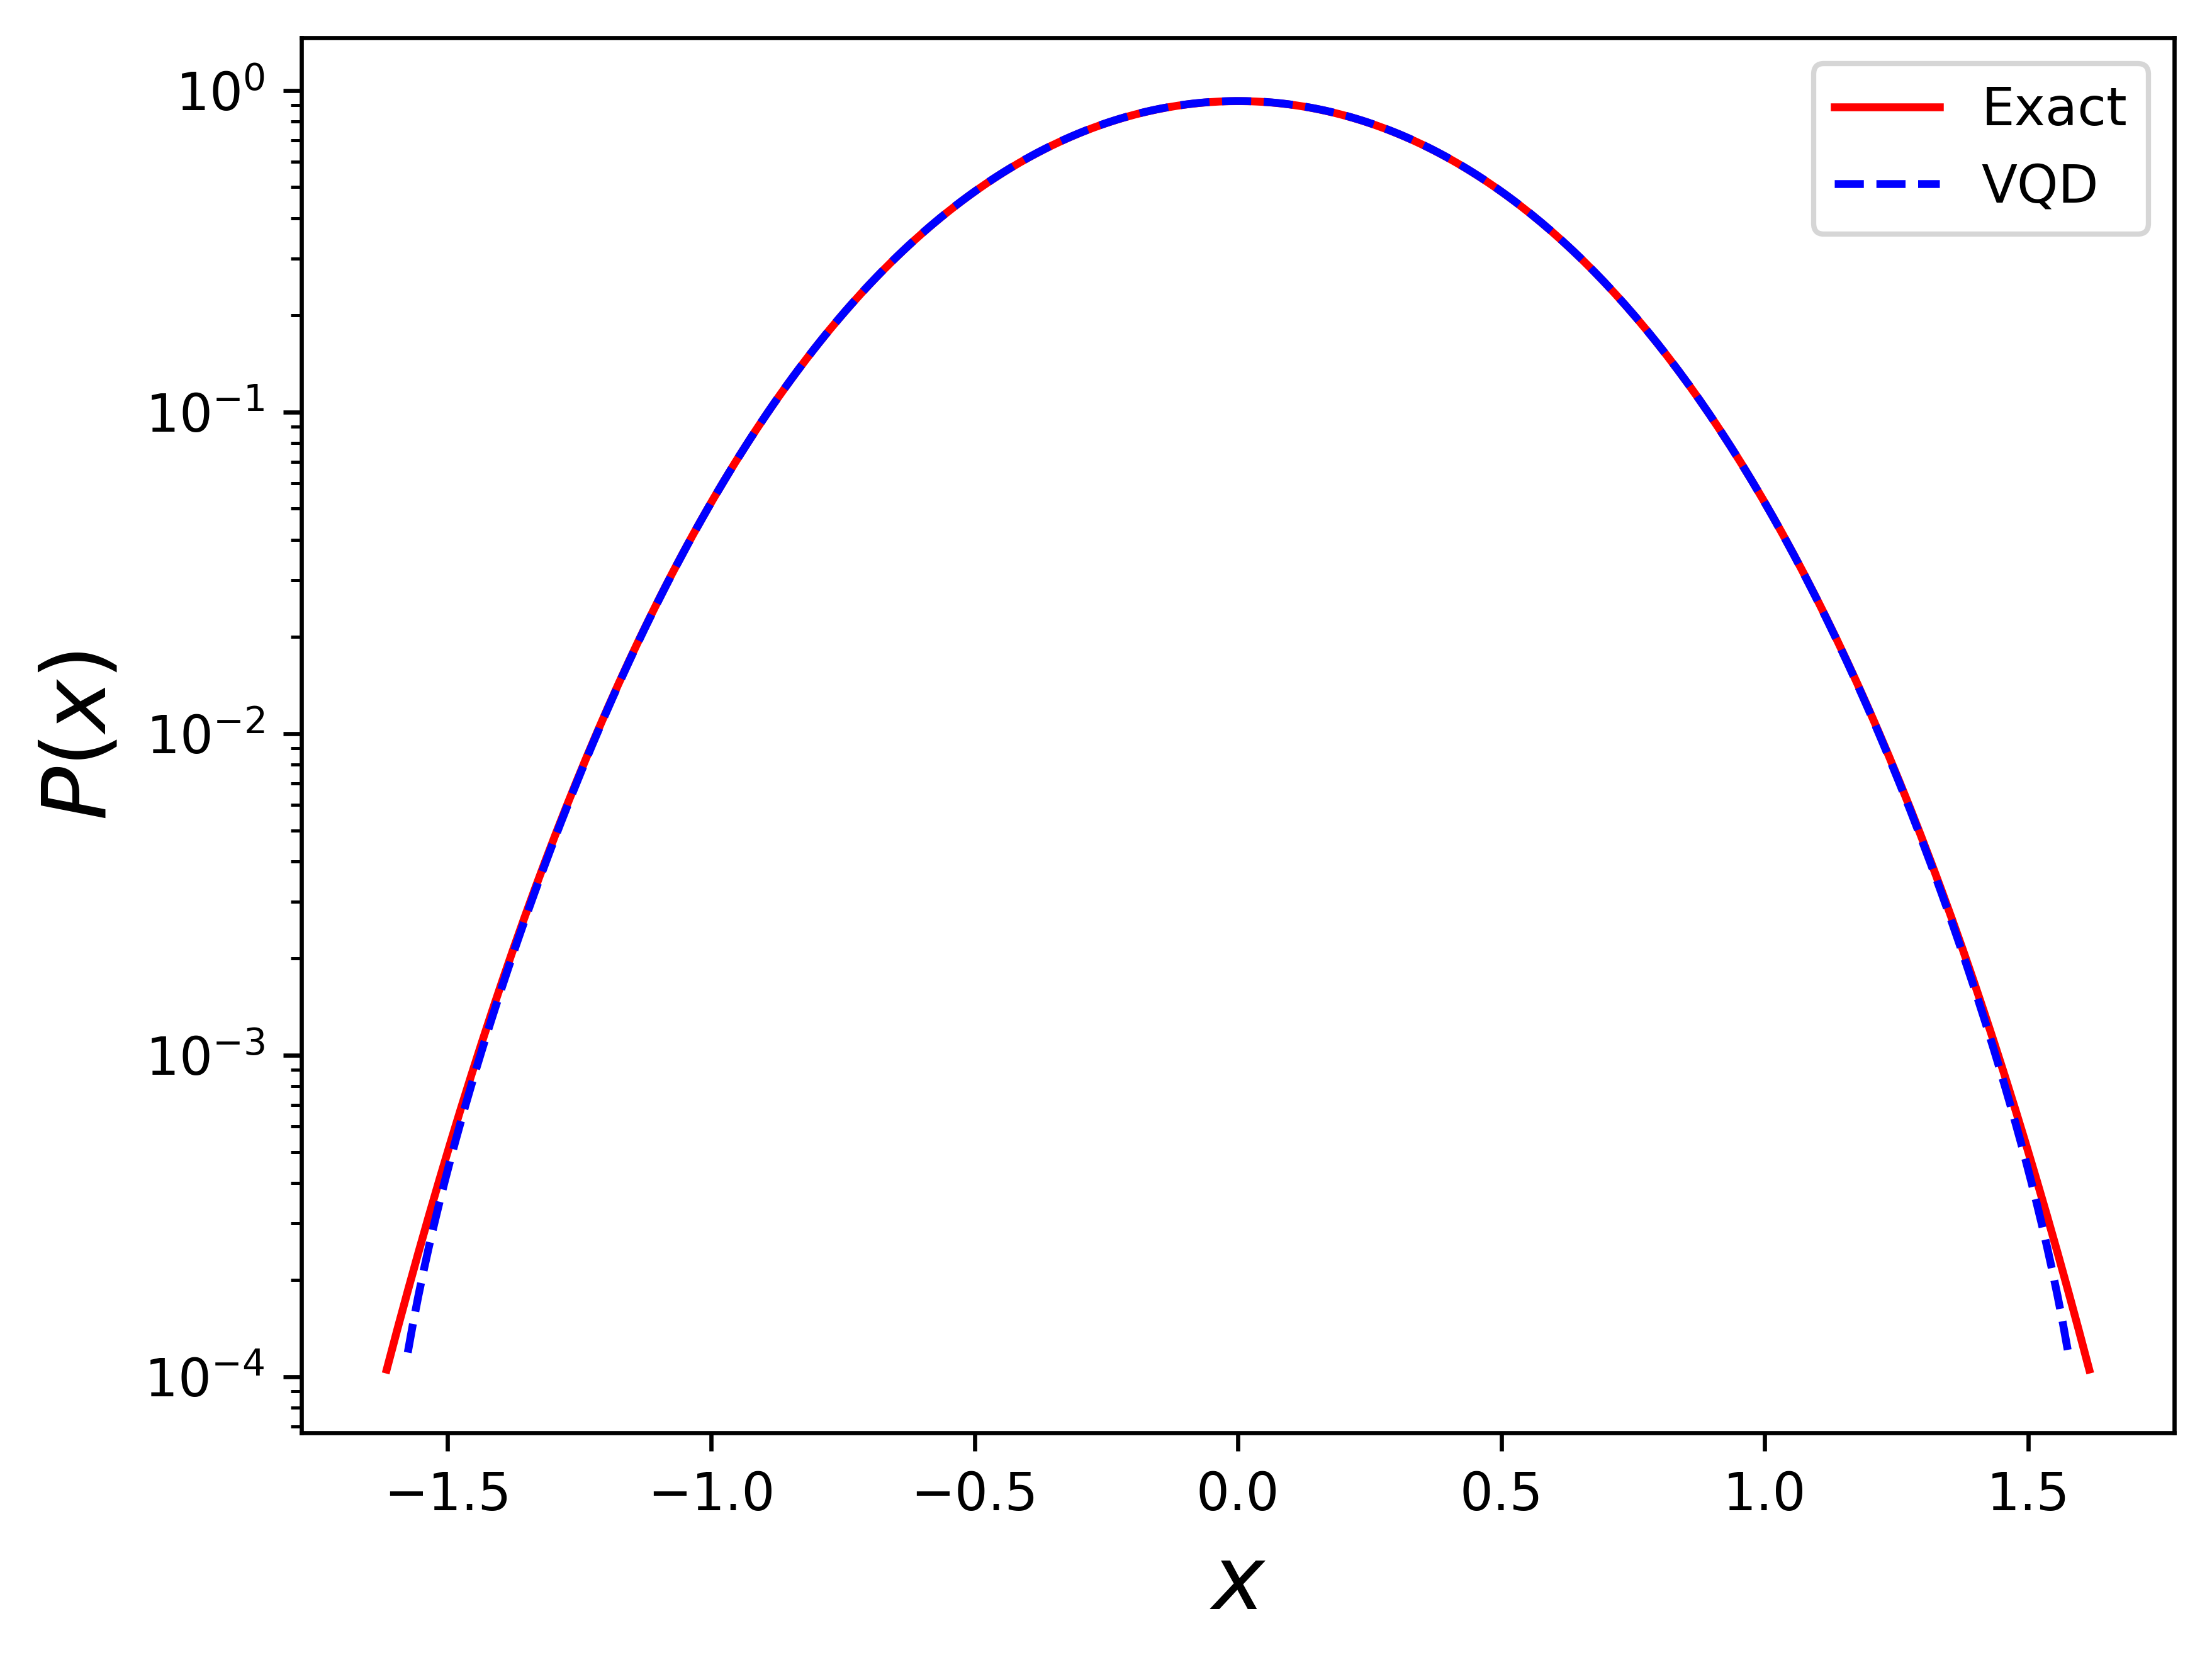

In [36]:
## Get the ground state PDF using the VQSVD zeromode
x_vqd, y_vqd = get_pdf(nmax, x, dx, L, shift, np.real(zeromode_vqd), normalize = True, make_even = True)

# Compute the standard deviation of the distribution
deviation = np.sqrt(np.var(y_vqd))

# Compute the expectation value of x
x_expectation, x_square_expectation = get_expectation(x, y_vqd)

# Compute the skewness and kurtosis of the distribution
skewness = skew(y_vqd, bias = False)
kurtosis_val = kurtosis(y_vqd)

# Compute the moments of the distribution
quantum_moments = get_moments(y_vqd, moments)

# # Compute the quantum CDF
# cum_quantum = np.cumsum(y_vqd)
# cum_quantum = cum_quantum/cum_quantum[-1] # normalization

# Compute the mean and variance of the distribution
mean_dis = np.mean(y_vqd)
variance = np.var(y_vqd)

# Compute the absolute error percentage in estimating the mean and variance
error_mean = abs(mean_dis - np.mean(y)) * 100
error_variance = abs(variance - np.var(y)) * 100

## Print the relevant results
# Print the standard deviation
print('The standard deviation of the distribution is:')
print(deviation)
print()

# Print the expectation value
print('The expectation value of x is:')
print(x_expectation)
print()

# Print the expectation value of x^2
print('The expectation value of x^2 is:')
print(x_square_expectation)
print()

# Print the skewness of the distribution
print('The skewness of the distribution is:')
print(skewness)
print()

# Print the kurtosis of the distribution
print('The kurtosis of the distribution is:')
print(kurtosis_val)
print()

# Print the moments of the distribution
print('The moments of the distribution are:')
print(quantum_moments)
print()

# Print the mean
print('The mean of the PDF estimated using VQSVD is:')
print(mean_dis)
print()

# Print the variance
print('The variance of the PDF estimated using VQSVD is:')
print(variance)
print()

# Print the error in estimating the mean
print('The error in estimating the mean is (percentage):')
print(error_mean)
print()

# Print the error in estimating the variance
print('The error in estimating the variance is (percentage):')
print(error_variance)
print()

# Comparison between the ground state PDFs (on a log scale)
y_cutoff = 1e-4

# Extract the relevant results 
x_classical, y_classical = cutoff_graph(x, y, y_cutoff) # exact analytical solution
x_quantum, y_quantum = cutoff_graph(x, y_vqd, y_cutoff) # QPE (or VQSVD)

# Plot
fig, ax = plt.subplots(dpi = 600)

# Plot the first set of data on a log base 2 scale
ax.plot(x_classical, y_classical, color = 'r', label = 'Exact')

# # Plot the exact diagonalization results
# ax.plot(x_diag, y_diag, '--b', label = "Exact diagonalization")

# Plot the second set of data on a log base 2 scale
ax.plot(x_quantum, y_quantum, '--b', label = 'VQD')

# Set y-axis to a log scale
ax.set_yscale('log')

# Set labels and title
ax.set_xlabel('$x$', fontsize = 17)
ax.set_ylabel('$P(x)$', fontsize = 17)

# Show a legend
ax.legend()

## Run noisy VQD on the Hermitian FPE operator matrix

In [37]:
eigenvalues, optimal_params, zeromode_vqd, num_parameters = run_VQD(matrix = matrix, k = 1, RealAmps = False, \
                                                                    bfgs = False, noise = True)

## Printing relevant results
# Print the eigenvalues
print('The eigenvalues obtained using VQD are:')
print(eigenvalues)
print()

# Print the optimal parameters
print('The optimal parameters of the variational ansatz for eigenvalue computations are:')
print(optimal_params)
print()

# Print the zeromode obtained
print('The zeromode obtained using the VQD algorithm is:')
print(zeromode_vqd)
print()

# Print the number of variational parameters
print('The number of variationa parameters being used is:')
print(num_parameters)
print()

INFO 2024-06-22 09:16:11,843 vqd.py:246] beta autoevaluated to 760743.4482850761
INFO 2024-06-22 09:16:11,844 spsa.py:321] SPSA: Starting calibration of learning rate and perturbation.
INFO 2024-06-22 09:16:11,894 runningpassmanager.py:247] Pass: ContainsInstruction - 0.00000 (ms)
INFO 2024-06-22 09:16:11,898 runningpassmanager.py:247] Pass: UnitarySynthesis - 0.00000 (ms)
INFO 2024-06-22 09:16:11,899 runningpassmanager.py:247] Pass: HighLevelSynthesis - 0.00000 (ms)
INFO 2024-06-22 09:16:11,904 runningpassmanager.py:247] Pass: Unroll3qOrMore - 2.99954 (ms)
INFO 2024-06-22 09:16:11,905 runningpassmanager.py:247] Pass: SetLayout - 0.00000 (ms)
INFO 2024-06-22 09:16:11,907 runningpassmanager.py:247] Pass: TrivialLayout - 0.00000 (ms)
INFO 2024-06-22 09:16:11,909 runningpassmanager.py:247] Pass: CheckMap - 0.00000 (ms)
INFO 2024-06-22 09:16:11,910 runningpassmanager.py:247] Pass: FullAncillaAllocation - 0.00000 (ms)
INFO 2024-06-22 09:16:11,914 runningpassmanager.py:247] Pass: EnlargeWith

The eigenvalues obtained using VQD are:
[-7549.83935721+0.j]

The optimal parameters of the variational ansatz for eigenvalue computations are:
[[-2.78508574 -2.24352832  0.6617141   2.60304123 -2.0296967  -1.43220535
  -1.185764    1.25415243  0.75427571 -2.96149046 -3.49565617  1.13943806
   1.28339612 -0.97260441 -1.11111473  3.75678857 -1.36728744  0.93584471
   0.47301463  3.58018671 -3.34894184  4.08579175  3.1747422  -0.30937706
  -2.71601684  1.22453886 -2.36962821 -1.91246684  2.44539098 -0.60484413]]

The zeromode obtained using the VQD algorithm is:
Statevector([0.18950893+0.02298435j, 0.2422838 +0.26386919j,
             0.00915722+0.09656457j, 0.09451501+0.40183289j,
             0.3958818 +0.17337032j, 0.31067188+0.39192343j,
             0.12006109+0.19109345j, 0.17681896+0.36921726j],
            dims=(2, 2, 2))

The number of variationa parameters being used is:
30



## Compute the steady-state PDF

In [38]:
## Get the ground state PDF using the VQD zeromode
x_vqd_noisy, y_vqd_noisy = get_pdf(nmax, x, dx, L, shift, np.real(zeromode_vqd), normalize = True, make_even = True)

# Comparison between the ground state PDFs (on a log scale)
y_cutoff = 1e-4

# Extract the relevant results 
x_quantum_noisy, y_quantum_noisy = cutoff_graph(x, y_vqd_noisy, y_cutoff) # VQD

## Visualization

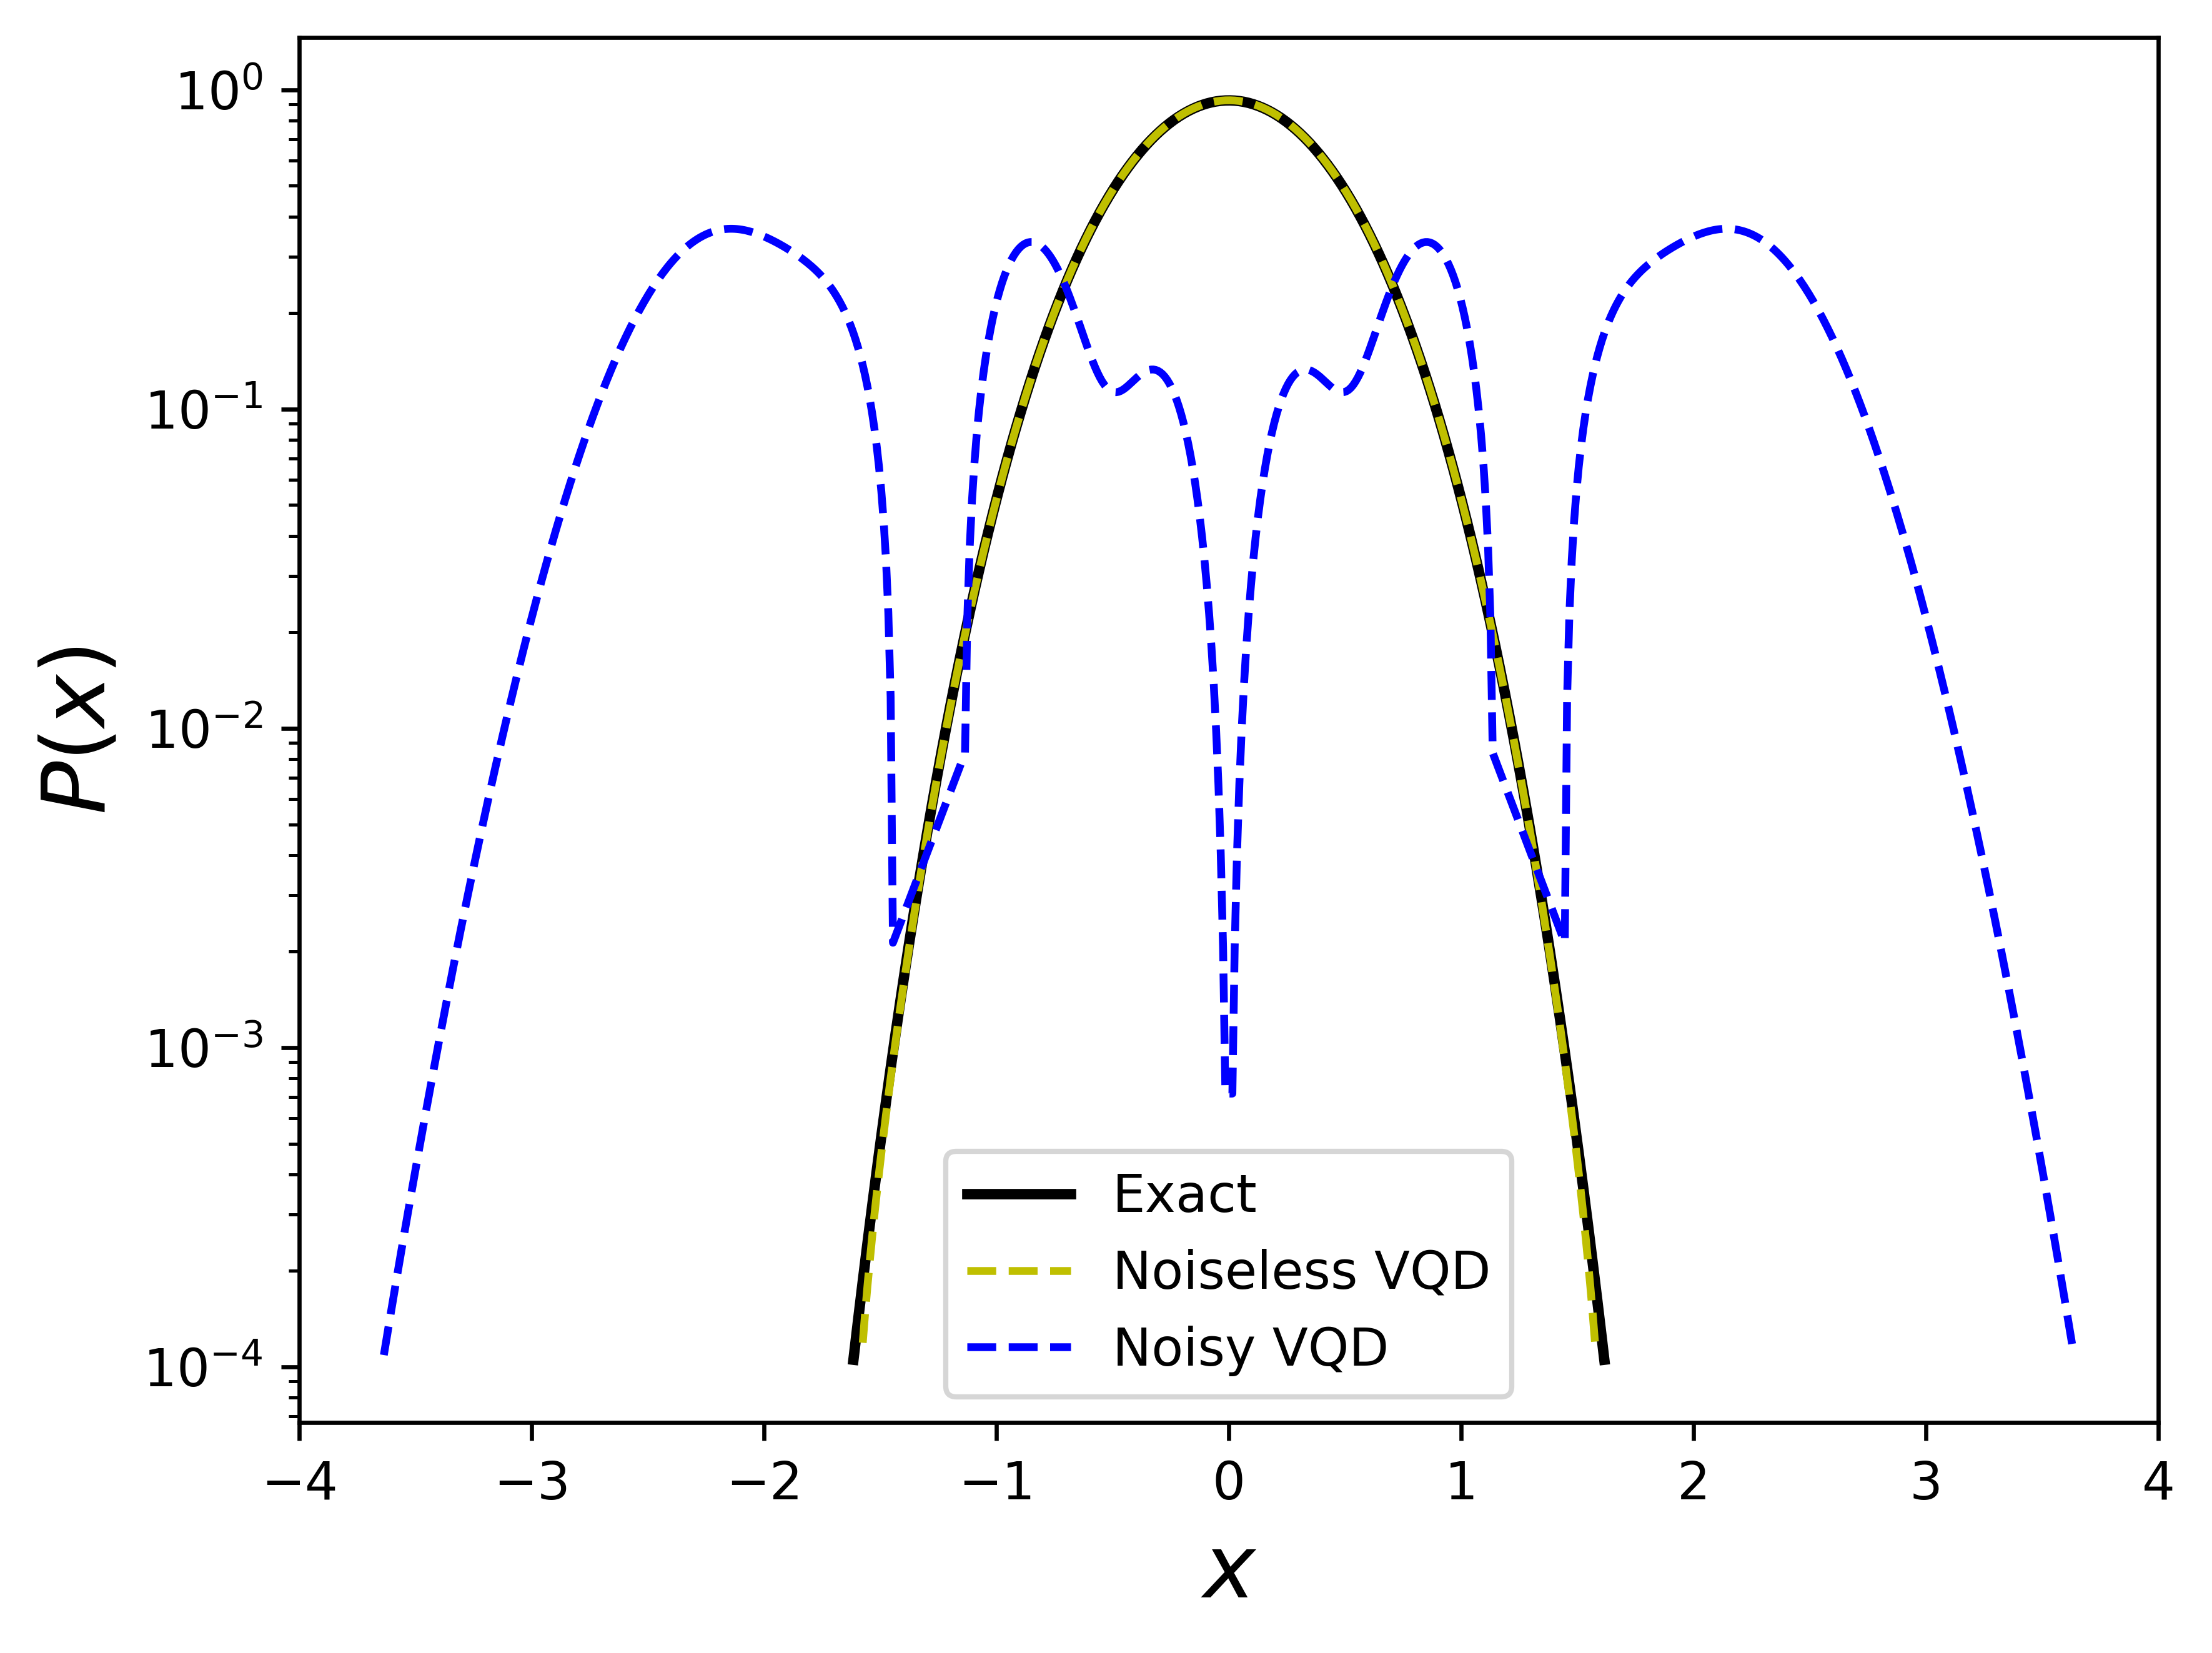

In [39]:
fig, ax = plt.subplots(dpi = 600)

ax.plot(x_classical, y_classical, color = 'k', linewidth = 2, label = 'Exact')
ax.plot(x_quantum, y_quantum, '--y', label = 'Noiseless VQD')
ax.plot(x_quantum_noisy, y_quantum_noisy, '--b', label = 'Noisy VQD')

# Set y-axis to a log scale
ax.set_yscale('log')

# Set labels and title
ax.set_xlabel('$x$', fontsize = 17)
ax.set_ylabel('$P(x)$', fontsize = 17)

# Show a legend
ax.legend(loc = 'best')